## Objective

Use Random Forests, see if $R^2$ improves from 0.56.

In [75]:
from __future__ import division
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = 20, 5
warnings.filterwarnings("ignore", category=DeprecationWarning)
sns.set_style("whitegrid")
sns.set_context("poster")

import os, sys
sys.path.append(os.path.join(os.path.dirname('.'), "../preprocessing"))
from helper_functions import dummify_cols_and_baselines, make_alphas, remove_outliers_by_type, transform_school, visualize_tree

In [2]:
df_orig = pd.read_pickle('../data/data_from_remove_from_dataset.pkl')
df_orig.shape

(516406, 40)

## Removing outliers

A standard procedure is to remove values further than 3 standard deviations from the mean. Since I have so many low values and some very high values, I anecdotally think that the low values are very likely to be true, and the high values not so much.

So, I will remove values further than 3 SDs from the median, by type.

Ideally, I would take into account the time dimension. I would like to do so given more time.

In [3]:
df1 = remove_outliers_by_type(df_orig, y_col='COMPLETION_HOURS_LOG_10')
df1.shape

../preprocessing/helper_functions.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  group[pd.np.abs(group - group.median()) > stds * group.std()] = pd.np.nan
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:2392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.where(-key, value, inplace=True)


(508653, 40)

I'm removing ~1.5% of my rows.

## Transformations

In [4]:
df2 = transform_school(df1)
df2.shape

../preprocessing/helper_functions.py:55: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  df.school = df.school.str.extract(r'(\d\d?)').astype(int)


(508653, 40)

## Only Recycling Cart Return TYPE

In [118]:
df3 = df2[df2.TYPE == 'Request for Snow Plowing'].drop('TYPE', axis=1)
df3.shape

(49135, 39)

## Choosing columns

In [119]:
cols_orig_dataset = ['COMPLETION_HOURS_LOG_10', 'SubmittedPhoto', 'Property_Type', 'Source', 'neighborhood_from_zip']
cols_census = ['race_white',
     'race_black',
     'race_asian',
     'race_hispanic',
     'race_other',
     'poverty_pop_below_poverty_level',
     'earned_income_per_capita',
     'poverty_pop_w_public_assistance',
     'poverty_pop_w_food_stamps',
     'poverty_pop_w_ssi',
     'school',
     'school_std_dev',
     'housing',
     'housing_std_dev',
     'bedroom',
     'bedroom_std_dev',
     'value',
     'value_std_dev',
     'rent',
     'rent_std_dev',
     'income',
     'income_std_dev']
cols_engineered = ['queue_wk', 'queue_wk_open', 'is_description']

In [120]:
df4 = df3[cols_orig_dataset + cols_census + cols_engineered]

## Dummify

In [121]:
cols_to_dummify = df4.dtypes[df4.dtypes == object].index
cols_to_dummify

Index([u'Property_Type', u'Source', u'neighborhood_from_zip', u'housing'], dtype='object')

In [122]:
df_dummified, baseline_cols = dummify_cols_and_baselines(df4, cols_to_dummify)

other is baseline 0 4
Twitter is baseline 1 4
West Roxbury is baseline 2 4
rent is baseline 3 4


In [123]:
df_dummified.shape

(49135, 52)

## Checking for co-linearity

in the hopes that it reduces my overfitting. At least it will make my model results more accurate.

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def get_vif(exog, exog_label_or_idx):
    """Now works w DataFrames, and adds the intercept column."""
    assert type(exog) == pd.DataFrame
    assert type(exog_label_or_idx) in (str, int)
    
    if type(exog_label_or_idx) == str:
        exog_idx = list(exog.columns).index(exog_label_or_idx)
    else:
        exog_idx = exog_label_or_idx
    
    exog_w_intercept = sm.add_constant(exog.as_matrix(), prepend=False)
    return variance_inflation_factor(exog_w_intercept, exog_idx)

def get_vifs(df, response):
    """Input the df and response column, and get the variance inflation factors for each of the predictors."""
    answer = {}
    cols = [i for i in df.columns if i != response]
    
    for col in cols:
        answer[col] = get_vif(df.drop(response, axis=1), col)
    
    return pd.Series(answer).sort_values(ascending=False)

In [ ]:
df_dummified.head(1).T

In [ ]:
vifs = get_vifs(df_dummified.drop(['SubmittedPhoto', 'is_description', 'race_other'], axis=1), 'COMPLETION_HOURS_LOG_10')

In [ ]:
vifs.head()

In [ ]:
vifs.index[:5]

## Running model

In [88]:
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.cross_validation import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor


In [124]:
cols_multicollinear = [u'race_white', u'race_black', u'race_hispanic', u'neighborhood_from_zip_Dorchester', u'earned_income_per_capita']

X_train, X_test, y_train, y_test = train_test_split(
    df_dummified.drop(['COMPLETION_HOURS_LOG_10'] + cols_multicollinear, axis=1), 
    df_dummified.COMPLETION_HOURS_LOG_10, 
    test_size=0.2, 
    random_state=300
)

In [90]:
pipe = make_pipeline(DecisionTreeRegressor())

In [14]:
cv = ShuffleSplit(X_train.shape[0], n_iter=5, test_size=0.2, random_state=300)

In [ ]:
# I wanted to use oob_score but need for loop
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html
# decided that with mulitple folds, each fold had similar performance, so went with k=1

params = {'decisiontreeregressor__max_depth': [2, 5, 10, 20], 
          'decisiontreeregressor__min_samples_split': [.01, .10, .20],
          'decisiontreeregressor__min_samples_leaf': [.003, .01, .03],
          'decisiontreeregressor__max_features': [35, 40, 44]}

# params = {'decisiontreeregressor__max_depth': [2, 5, 10], 
#           'decisiontreeregressor__min_samples_split': [.05],
#           'decisiontreeregressor__min_samples_leaf': [.05],
#           'decisiontreeregressor__max_features': [None]}

# params = {'decisiontreeregressor__max_depth': [2], 
#           'decisiontreeregressor__min_samples_split': [.05],
#           'decisiontreeregressor__min_samples_leaf': [.05],
#           'decisiontreeregressor__max_features': [None]}

model = GridSearchCV(pipe, param_grid=params, n_jobs=-1, cv=cv, verbose=1)
model.fit(X_train, y_train)
results = pd.DataFrame(model.cv_results_).T

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   53.0s


In [112]:
model.best_score_

0.48454390073233888

In [113]:
model.best_params_

{'decisiontreeregressor__max_depth': 10,
 'decisiontreeregressor__max_features': 44,
 'decisiontreeregressor__min_samples_leaf': 0.01,
 'decisiontreeregressor__min_samples_split': 0.1}

In [94]:
results.iloc[2:8].T.sort_values('mean_test_score', ascending=False).T

,55,103,91,100,64,92,58,83,76,104,...,66,7,62,54,72,63,90,8,81,99
mean_test_score,0.486192,0.485544,0.483946,0.482889,0.476049,0.475632,0.474116,0.474052,0.473601,0.47323,...,0.386321,0.357538,0.351328,0.351073,0.345841,0.335229,0.327582,0.320903,0.305663,0.28584
mean_train_score,0.544701,0.548803,0.550101,0.554321,0.543251,0.49717,0.545995,0.502573,0.546634,0.49549,...,0.668122,0.365065,0.401142,0.752712,0.766677,0.748819,0.809462,0.304066,0.812109,0.82237
param_decisiontreeregressor__max_depth,10,20,20,20,10,20,10,20,10,20,...,10,2,10,10,10,10,20,2,20,20
param_decisiontreeregressor__max_features,35,44,40,44,40,40,35,35,44,44,...,40,35,35,35,44,40,40,35,35,44
param_decisiontreeregressor__min_samples_leaf,0.003,0.01,0.003,0.003,0.003,0.003,0.01,0.003,0.01,0.01,...,0.01,0.03,0.03,0.003,0.003,0.003,0.003,0.03,0.003,0.003
param_decisiontreeregressor__min_samples_split,0.1,0.1,0.1,0.1,0.1,0.2,0.1,0.2,0.1,0.2,...,0.01,0.1,0.2,0.01,0.01,0.01,0.01,0.2,0.01,0.01


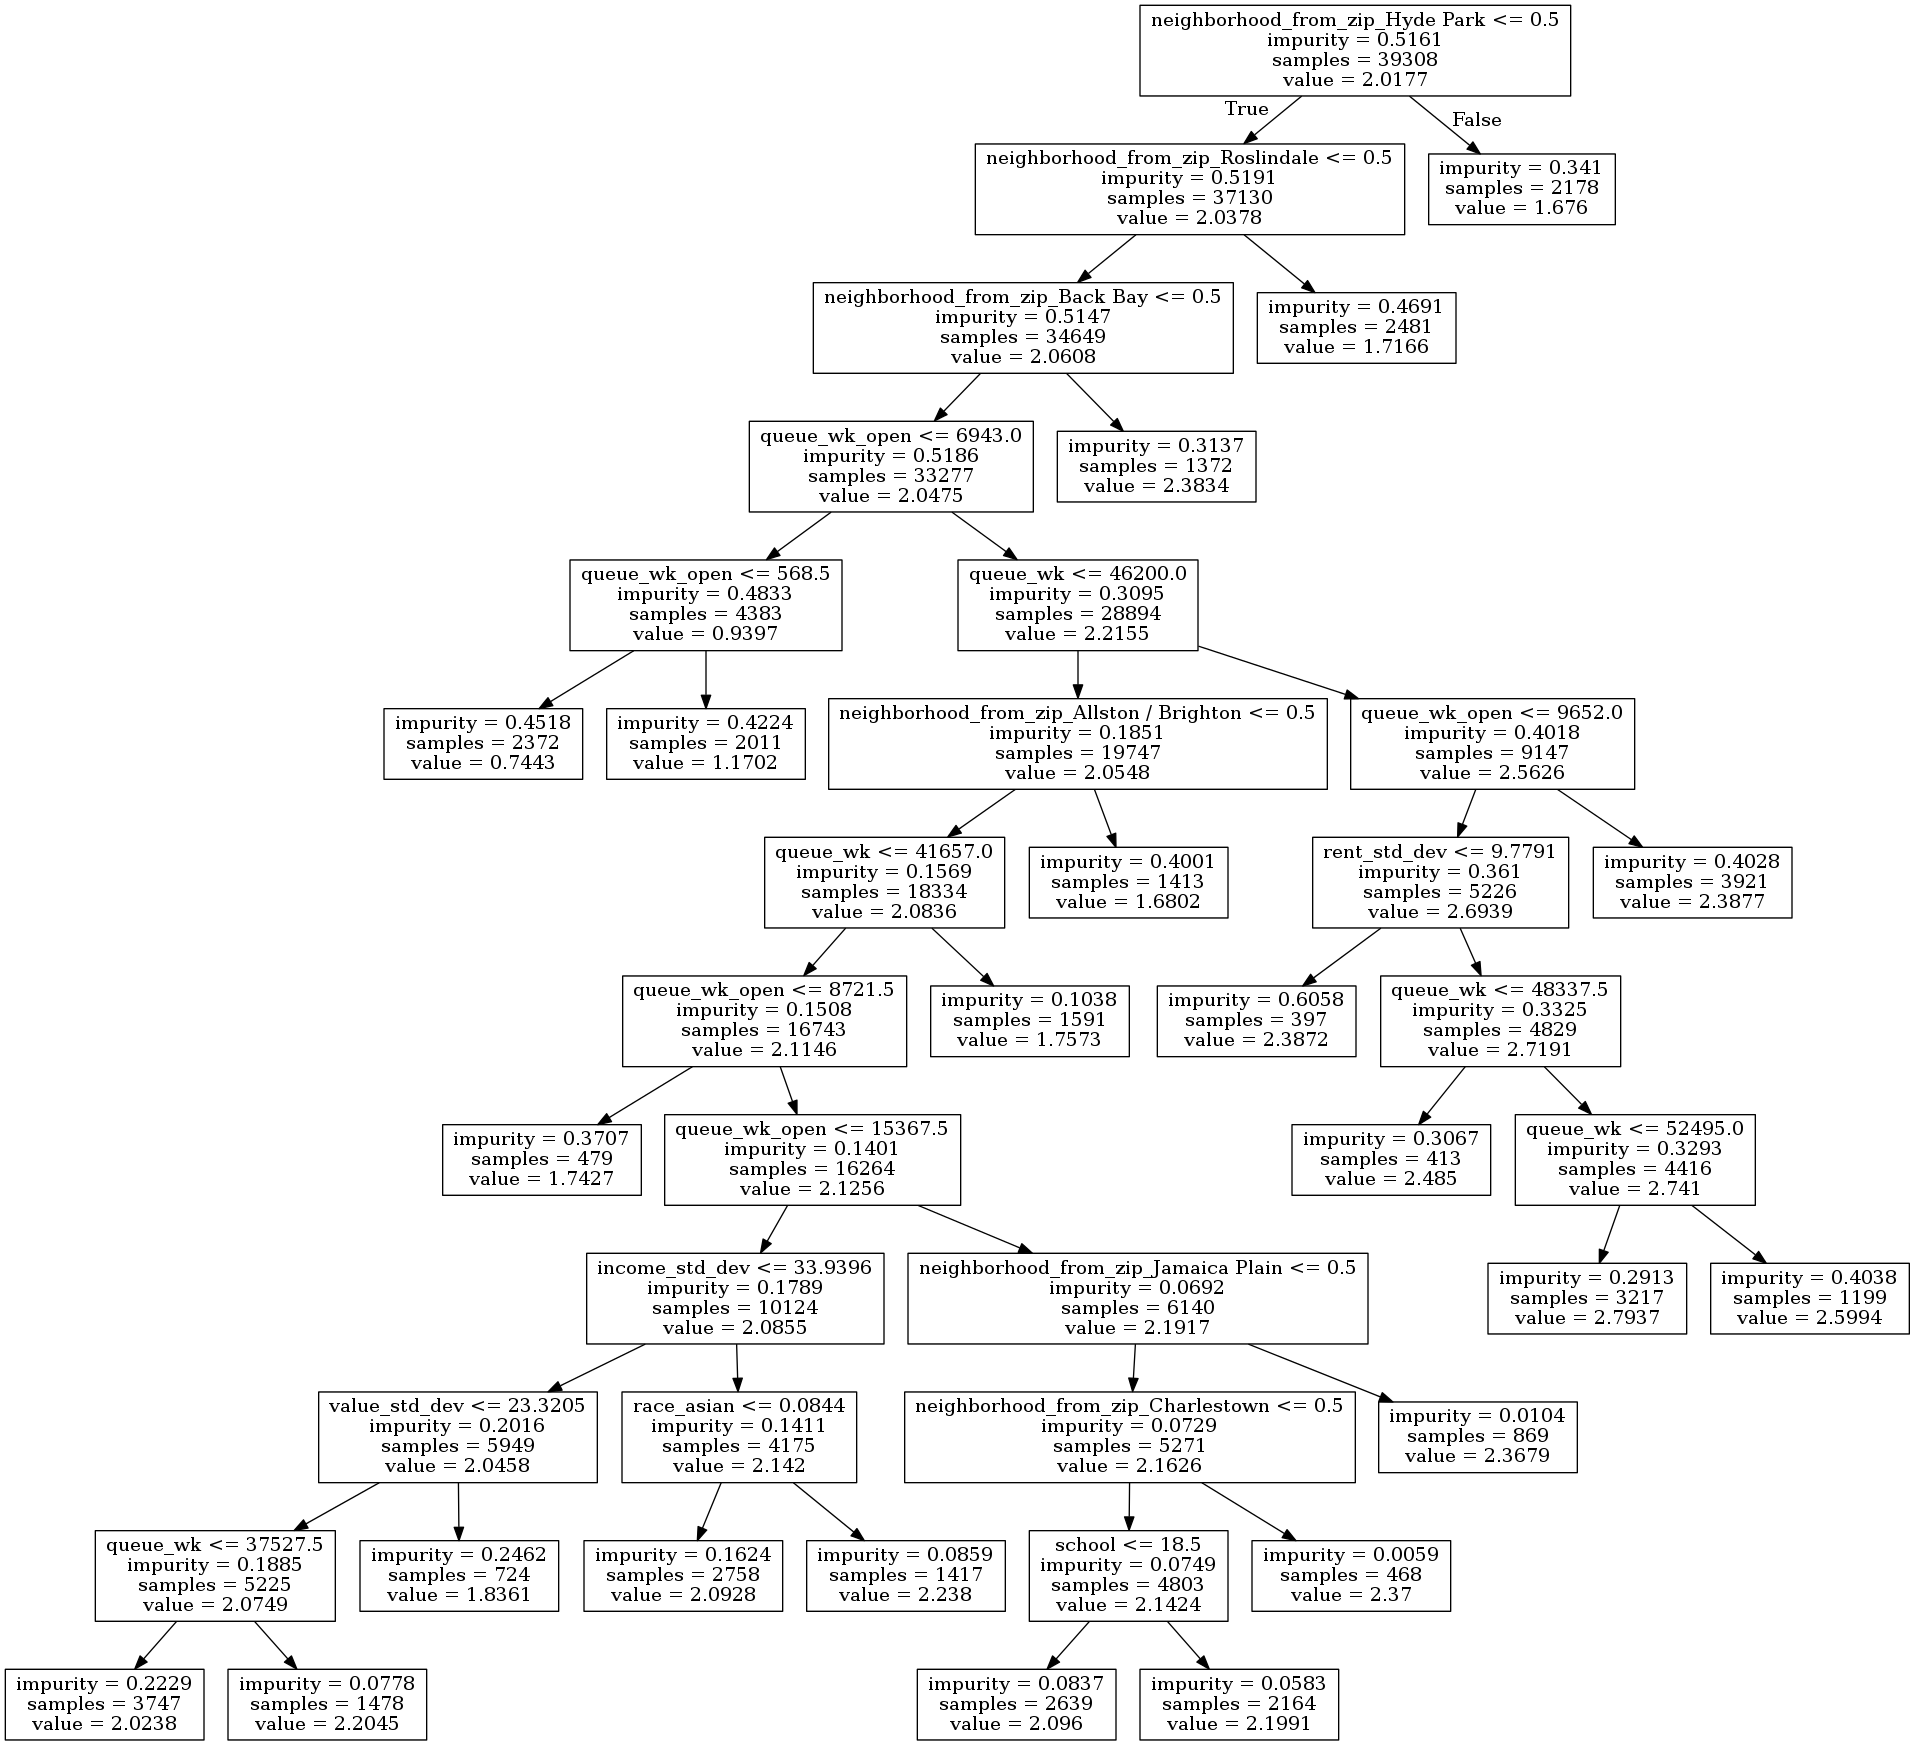

In [127]:
visualize_tree(model.best_estimator_.steps[-1][-1].tree_, X_train.columns)

In [96]:
y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred)**0.5

0.47525281085161303

## Trying RFs to see how much better score can be

In [115]:
model.best_params_

{'decisiontreeregressor__max_depth': 10,
 'decisiontreeregressor__max_features': 44,
 'decisiontreeregressor__min_samples_leaf': 0.01,
 'decisiontreeregressor__min_samples_split': 0.1}

In [99]:
pipe1 = make_pipeline(RandomForestRegressor())

In [116]:
params = {'randomforestregressor__max_depth': [10], 
          'randomforestregressor__max_features': [35, 44], # for some reason 45 best out of [7, 15, 35, 45]          
          'randomforestregressor__min_samples_leaf': [.01],
          'randomforestregressor__min_samples_split': [.1],
          'randomforestregressor__n_estimators': [300]}

model1 = GridSearchCV(pipe1, param_grid=params, n_jobs=1, cv=cv, verbose=1)
model1.fit(X_train, y_train)
results1 = pd.DataFrame(model1.cv_results_).T

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.7s finished


In [117]:
model1.best_score_

0.50231101688437341

In [104]:
model1.best_params_

{'randomforestregressor__max_depth': 30,
 'randomforestregressor__max_features': 35,
 'randomforestregressor__min_samples_leaf': 0.003,
 'randomforestregressor__min_samples_split': 0.1,
 'randomforestregressor__n_estimators': 300}

## Appendix

In [ ]:
sns.regplot(
    x='param_randomforestregressor__max_depth',
    y='mean_test_score',
    data=results.T[['param_randomforestregressor__max_depth', 'mean_test_score']], 
    fit_reg=False
);

In [ ]:
sns.regplot(
    x='param_randomforestregressor__n_estimators',
    y='mean_test_score',
    data=results.T[['param_randomforestregressor__n_estimators', 'mean_test_score']], 
    fit_reg=False
);

### Variable Importance Table

To learn which nodes most affect the completion time

In [ ]:
feature_importances = pd.np.argsort(model.best_estimator_.steps[0][-1].feature_importances_)
features = list(df_dummified.drop('COMPLETION_HOURS_LOG_10', axis=1).columns[feature_importances[-1:-11:-1]])
pd.DataFrame({'top ten features': features})

In [ ]:
n = 10 # top 10 features

importances = model.best_estimator_.steps[0][-1].feature_importances_[:n]
std = pd.np.std([tree.feature_importances_ for tree in model.best_estimator_.steps[0][-1]], axis=0)
indices = pd.np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(n):
    print("%d. %s (%f)" % (f + 1, features[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices], yerr=std[indices], color="r", align="center")
plt.xticks(range(10), indices)
plt.xlim([-1, 10])
plt.show()